## BLSTM with SEQ_LEN 120 partially removed stopwords

In [1]:
import pandas as pd
import numpy as np
from random import shuffle

import gensim
from gensim.models.word2vec import Word2Vec
from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords

from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Embedding, CuDNNLSTM, Bidirectional
from keras.optimizers import Adam, Adagrad

C:\Users\Aman Deep Singh\Anaconda3\envs\tf-gpu\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


In [2]:
# F1 metrics function
def f1(y_true, y_pred):
    '''returns the f1 score given targets and predictions'''
    
    def recall(y_true, y_pred):
        true_pos = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_pos = K.sum(K.round(K.clip(y_true, 0, 1)))
        rec = true_pos / (possible_pos + K.epsilon())
        return rec
    
    def precision(y_true, y_pred):
        true_pos = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_pos = K.sum(K.round(K.clip(y_pred, 0, 1)))
        prec = true_pos / (predicted_pos + K.epsilon())
        return prec
    
    _precision = precision(y_true, y_pred)
    _recall = recall(y_true, y_pred)
    return 2 * ((_precision * _recall) / (_precision + _recall + K.epsilon()))

In [3]:
df = pd.read_csv('D:/Datasets/hackerearth/hm_train.csv')
df.drop(['num_sentence'], axis=1, inplace=True)
labels = df.predicted_category
df.drop(['predicted_category'], axis=1, inplace=True)

print(df.shape, len(labels))

(60321, 3) 60321


In [4]:
df.head()

,hmid,reflection_period,cleaned_hm
0,27673,24h,I went on a successful date with someone I fel...
1,27674,24h,I was happy when my son got 90% marks in his e...
2,27675,24h,I went to the gym this morning and did yoga.
3,27676,24h,We had a serious talk with some friends of our...
4,27677,24h,I went with grandchildren to butterfly display...


In [5]:
df.cleaned_hm = df.cleaned_hm.str.lower()

In [6]:
SEQ_LEN = 120
EPOCHS = 20

In [7]:
def remove_stopwords(sentence):
    # removing some known errors and differences between american and british english
    sentence = sentence.replace("\n", " ").replace(";", " ; ").replace(":", " : ").replace(",", " , ").replace(".", " . ").replace("?", " ? ").replace("/", " / ").replace("\\", " \ ").replace("'s", "").replace("n't", " not").replace("travelled", "traveled").replace("traveller", "traveler").replace("cancelled", "canceled").replace("favourite", "favorite").replace("i'm", "i am").replace("i've", "i have").replace("colour", "color").replace("neighbour", "neighbor").replace("jewellery", "jewelry").replace("theatre", "theater").replace("i'd", "i would").replace("didnt", "did not").replace("doesnt", "does not").replace("wasnt", "was not").replace("programme", "program").replace("organise", "organize")
    
    split = sentence.split()
    if len(split) > SEQ_LEN:
        return ' '.join([w for w in sentence.split() if w not in stopwords.words('english')])
    else:
        return sentence

In [8]:
def completely_remove_stopwords(sentence):
    sentence = sentence.replace("\n", " ").replace(";", " ; ").replace(":", " : ").replace(",", " , ").replace(".", " . ").replace("?", " ? ").replace("/", " / ").replace("\\", " \ ").replace("'s", "").replace("n't", " not").replace("travelled", "traveled").replace("favourite", "favorite").replace("i'm", "i am").replace("i've", "i have").replace("colour", "color").replace("neighbour", "neighbor").replace("jewellery", "jewelry").replace("theatre", "theater").replace("i'd", "i would").replace("didnt", "did not").replace("doesnt", "does not").replace("wasnt", "was not").replace("programme", "program").replace("organise", "organize")
    
    return ' '.join([w for w in sentence.split() if w not in stopwords.words('english')])

In [9]:
df['cleaned_hm2'] = df.cleaned_hm.apply(remove_stopwords)

In [10]:
df.drop(['cleaned_hm'], axis=1, inplace=True)

In [11]:
df.head()

,hmid,reflection_period,cleaned_hm2
0,27673,24h,i went on a successful date with someone i fel...
1,27674,24h,i was happy when my son got 90% marks in his e...
2,27675,24h,i went to the gym this morning and did yoga .
3,27676,24h,we had a serious talk with some friends of our...
4,27677,24h,i went with grandchildren to butterfly display...


In [12]:
t = Tokenizer()
t.fit_on_texts(df.cleaned_hm2)
VOCAB_SIZE = len(t.word_index) + 1

In [13]:
encoded_train_set = t.texts_to_sequences(df.cleaned_hm2)
len(encoded_train_set)

60321

In [14]:
lengths = []
for doc in encoded_train_set:
    lengths.append(len(doc))

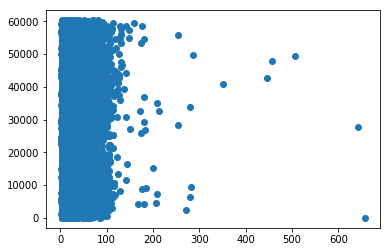

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(lengths, range(len(lengths)))
plt.show()

In [16]:
df['tokens'] = encoded_train_set

In [17]:
df.head()

,hmid,reflection_period,cleaned_hm2,tokens
0,27673,24h,i went on a successful date with someone i fel...,"[1, 23, 16, 3, 765, 321, 12, 287, 1, 94, 12604..."
1,27674,24h,i was happy when my son got 90% marks in his e...,"[1, 7, 15, 21, 2, 66, 17, 2282, 1424, 10, 67, ..."
2,27675,24h,i went to the gym this morning and did yoga .,"[1, 23, 4, 6, 398, 36, 96, 5, 95, 930]"
3,27676,24h,we had a serious talk with some friends of our...,"[22, 18, 3, 1618, 319, 12, 46, 50, 11, 3803, 1..."
4,27677,24h,i went with grandchildren to butterfly display...,"[1, 23, 12, 1908, 4, 3804, 4201, 20, 12606, 12..."


In [18]:
df.drop(['cleaned_hm2'], axis=1, inplace=True)

In [19]:
df.head()

,hmid,reflection_period,tokens
0,27673,24h,"[1, 23, 16, 3, 765, 321, 12, 287, 1, 94, 12604..."
1,27674,24h,"[1, 7, 15, 21, 2, 66, 17, 2282, 1424, 10, 67, ..."
2,27675,24h,"[1, 23, 4, 6, 398, 36, 96, 5, 95, 930]"
3,27676,24h,"[22, 18, 3, 1618, 319, 12, 46, 50, 11, 3803, 1..."
4,27677,24h,"[1, 23, 12, 1908, 4, 3804, 4201, 20, 12606, 12..."


In [20]:
np.mean(lengths)

18.309875499411483

In [21]:
padded_train_docs = pad_sequences(encoded_train_set, maxlen=SEQ_LEN, padding='post')

In [22]:
train_paddocs = []
for doc in padded_train_docs:
    train_paddocs.append(list(doc))

In [23]:
df['tokens2'] = train_paddocs

In [24]:
lengths = []
for doc in train_paddocs:
    lengths.append(len(doc))

In [25]:
np.mean(lengths)

120.0

In [26]:
df.drop(['tokens'], axis=1, inplace=True)

In [27]:
df.rename(index=str, columns={'tokens2': 'tokens'}, inplace=True)

In [28]:
df.head()

,hmid,reflection_period,tokens
0,27673,24h,"[1, 23, 16, 3, 765, 321, 12, 287, 1, 94, 12604..."
1,27674,24h,"[1, 7, 15, 21, 2, 66, 17, 2282, 1424, 10, 67, ..."
2,27675,24h,"[1, 23, 4, 6, 398, 36, 96, 5, 95, 930, 0, 0, 0..."
3,27676,24h,"[22, 18, 3, 1618, 319, 12, 46, 50, 11, 3803, 1..."
4,27677,24h,"[1, 23, 12, 1908, 4, 3804, 4201, 20, 12606, 12..."


In [29]:
embeddings_index = gensim.models.KeyedVectors.load_word2vec_format('D:/Datasets/embeddings/Word2Vec/GoogleNews-vectors-negative300.bin', binary=True)

In [30]:
VOCAB_SIZE

20832

In [31]:
embedding_matrix = np.zeros((VOCAB_SIZE, 300))
count = 0
for word, i in t.word_index.items():
    try:
        embedding_vector = embeddings_index[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        print(f'Did not find {word}')
        count += 1

count

Did not find a
Did not find to
Did not find and
Did not find of

Did not find 10
Did not find mturk
Did not find 24
Did not find 20
Did not find 100
Did not find 30
Did not find 15
Did not find 50
Did not find 12
Did not find 00
Did not find 2017
Did not find 25
Did not find 40
Did not find 11
Did not find 500
Did not find 13
Did not find 000
Did not find 200
Did not find i'll
Did not find donat
Did not find 14
Did not find 300
Did not find 60
Did not find travelling
Did not find judgements
Did not find 250
Did not find 18
Did not find 80
Did not find 10th
Did not find 1000
Did not find 45
Did not find 16
Did not find 70
Did not find 17
Did not find 90
Did not find morty
Did not find ooty
Did not find 2000
Did not find ps4
Did not find 75
Did not find fianca
Did not find 30th
Did not find eudaimonia
Did not find jigarthanda
Did not find a3i
Did not find iave
Did not find 2016
Did not find 150
Did not find 99
Did not find thatas
Did not find learnt
Did not find eudaimonic
Did not find w

Did not find japaneses
Did not find pupper
Did not find creditkarma
Did not find that'd
Did not find hersheys

Did not find cht
Did not find chickfila


Did not find 200k
Did not find yessica
Did not find mindy
Did not find ptkgrecpi1i


Did not find hersh
Did not find somenthing
Did not find ceasars
Did not find roleplayed



Did not find enjoyful
Did not find procert
Did not find norvin
Did not find pgy2
Did not find slothrust
Did not find patiantly
Did not find ahey
Did not find hereas
Did not find 'munar
Did not find talesa
Did not find kanan
Did not find devan
Did not find msa
Did not find fauno
Did not find windermere
Did not find antony
Did not find iching
Did not find animels
Did not find beutifull
Did not find 'on
Did not find job'
Did not find cude
Did not find v60
Did not find kulu
Did not find 186
Did not find medel
Did not find verymuch
Did not find manytimes
Did not find apfc
Did not find 147
Did not find patrickas
Did not find nugs
Did not find pgcert
Did not find retrei

Did not find nutureshock
Did not find merryman
Did not find acancer
Did not find asunshinea
Did not find abasket
Did not find customersa
Did not find woodford
Did not find altima
Did not find 215
Did not find fighted
Did not find preassure
Did not find cindrella
Did not find iobit
Did not find 150cc
Did not find sweing
Did not find jeasus
Did not find aakshayatriya
Did not find 'god
Did not find blindman
Did not find mandovi
Did not find alberquerue
Did not find comtrol
Did not find mushroomhead
Did not find aqes

Did not find coakers
Did not find sphaghetti
Did not find gaurdians
Did not find saturnz
Did not find barz
Did not find 'baby'
Did not find gettijg

Did not find albania
Did not find brockmire
Did not find budritas
Did not find 428i
Did not find picknick
Did not find liquidsky
Did not find jarrad
Did not find omegle
Did not find 2reply
Did not find ciroc
Did not find 'overrule'
Did not find vallejo
Did not find seti
Did not find oubre
Did not find olynek
Did not find foyt
Did

2707

In [32]:
embedding_matrix.shape

(20832, 300)

In [33]:
df['24h'] = df.reflection_period == '24h'
df['3m'] = df.reflection_period == '3m'

In [37]:
df.drop(['reflection_period'], axis=1, inplace=True)

In [40]:
df.head()

,hmid,tokens,24h,3m
0,27673,"[1, 23, 16, 3, 765, 321, 12, 287, 1, 94, 12604...",True,False
1,27674,"[1, 7, 15, 21, 2, 66, 17, 2282, 1424, 10, 67, ...",True,False
2,27675,"[1, 23, 4, 6, 398, 36, 96, 5, 95, 930, 0, 0, 0...",True,False
3,27676,"[22, 18, 3, 1618, 319, 12, 46, 50, 11, 3803, 1...",True,False
4,27677,"[1, 23, 12, 1908, 4, 3804, 4201, 20, 12606, 12...",True,False


In [42]:
print(df.shape, len(labels))

(60321, 4) 60321


In [43]:
df.to_csv('D:/Datasets/hackerearth/hm_train-tok-nstp.csv')

In [44]:
labels_to_cats = {'achievement':      (1, 0, 0, 0, 0, 0, 0),
                  'affection':        (0, 1, 0, 0, 0, 0, 0),
                  'enjoy_the_moment': (0, 0, 1, 0, 0, 0, 0),
                  'nature':           (0, 0, 0, 1, 0, 0, 0),
                  'exercise':         (0, 0, 0, 0, 1, 0, 0),
                  'bonding':          (0, 0, 0, 0, 0, 1, 0),
                  'leisure':          (0, 0, 0, 0, 0, 0, 1)}

In [45]:
cats_to_labels = dict()
for k, v in labels_to_cats.items():
    cats_to_labels[v] = k

cats_to_labels

{(1, 0, 0, 0, 0, 0, 0): 'achievement',
 (0, 1, 0, 0, 0, 0, 0): 'affection',
 (0, 0, 1, 0, 0, 0, 0): 'enjoy_the_moment',
 (0, 0, 0, 1, 0, 0, 0): 'nature',
 (0, 0, 0, 0, 1, 0, 0): 'exercise',
 (0, 0, 0, 0, 0, 1, 0): 'bonding',
 (0, 0, 0, 0, 0, 0, 1): 'leisure'}

In [46]:
y = []
for label in labels:
    y.append(labels_to_cats[label])

y = np.array(y)
len(y)

60321

In [48]:
len(df.tokens[0])

120

In [105]:
input_tensor = Input(shape=(SEQ_LEN,), dtype='int32')
e = Embedding(VOCAB_SIZE, 300, weights=[embedding_matrix], input_length=SEQ_LEN, trainable=False)(input_tensor)
x = Bidirectional(CuDNNLSTM(256, return_sequences=True))(e)
x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(x)
x = Bidirectional(CuDNNLSTM(64, return_sequences=False))(x)
x = Dense(64, activation='relu')(x)
x = Dense(7, activation='softmax')(x)
model = Model(input_tensor, x)

In [106]:
model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy', f1])

In [107]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 120)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 120, 300)          6249600   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 120, 512)          1142784   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 120, 256)          657408    
_________________________________________________________________
bidirectional_9 (Bidirection (None, 128)               164864    
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 7)                 455       
Total para

In [108]:
x_train, x_val, y_train, y_val = train_test_split(df, y, test_size=0.2)

In [109]:
print(x_train.shape, x_val.shape)

(48256, 4) (12065, 4)


In [110]:
print(y_train.shape, y_val.shape)

(48256, 7) (12065, 7)


In [111]:
x_train_reshape = x_train.copy()
x_train_reshape = x_train_reshape.tokens

In [112]:
x_train_new = []
for element in x_train_reshape:
    x_train_new.append(np.array(element))
x_train_new = np.array(x_train_new)
x_train_new.shape

(48256, 120)

In [113]:
x_val_reshape = x_val.copy()
x_val_reshape = x_val_reshape.tokens

In [114]:
x_val_new = []
for element in x_val_reshape:
    x_val_new.append(np.array(element))
x_val_new = np.array(x_val_new)
x_val_new.shape

(12065, 120)

In [120]:
model.fit(x_train_new, y_train, epochs=EPOCHS, verbose=2)

Epoch 1/20
 - 71s - loss: 0.0374 - acc: 0.9869 - f1: 0.9868
Epoch 2/20
 - 77s - loss: 0.0343 - acc: 0.9877 - f1: 0.9877
Epoch 3/20
 - 75s - loss: 0.0341 - acc: 0.9882 - f1: 0.9883
Epoch 4/20
 - 69s - loss: 0.0304 - acc: 0.9891 - f1: 0.9891
Epoch 5/20
 - 67s - loss: 0.0326 - acc: 0.9886 - f1: 0.9886
Epoch 6/20
 - 66s - loss: 0.0326 - acc: 0.9887 - f1: 0.9888
Epoch 7/20
 - 66s - loss: 0.0218 - acc: 0.9928 - f1: 0.9928
Epoch 8/20
 - 66s - loss: 0.0284 - acc: 0.9900 - f1: 0.9899
Epoch 9/20
 - 66s - loss: 0.0260 - acc: 0.9905 - f1: 0.9905
Epoch 10/20
 - 72s - loss: 0.0274 - acc: 0.9909 - f1: 0.9909
Epoch 11/20
 - 73s - loss: 0.0242 - acc: 0.9919 - f1: 0.9920
Epoch 12/20
 - 78s - loss: 0.0249 - acc: 0.9917 - f1: 0.9916
Epoch 13/20
 - 79s - loss: 0.0234 - acc: 0.9922 - f1: 0.9922
Epoch 14/20
 - 77s - loss: 0.0229 - acc: 0.9924 - f1: 0.9924
Epoch 15/20
 - 82s - loss: 0.0219 - acc: 0.9931 - f1: 0.9931
Epoch 16/20
 - 74s - loss: 0.0241 - acc: 0.9919 - f1: 0.9919
Epoch 17/20
 - 72s - loss: 0.0175

In [121]:
model.save('D:/Datasets/hackerearth/models/word2vec-blstm256-bltsm128-blstm64-d64-e60.h5')

In [68]:
df_test = pd.read_csv('D:/Datasets/hackerearth/hm_test.csv')
df_test.drop(['num_sentence'], axis=1, inplace=True)
df_test.head()

,hmid,reflection_period,cleaned_hm
0,88305,3m,I spent the weekend in Chicago with my friends.
1,88306,3m,We moved back into our house after a remodel. ...
2,88307,3m,My fiance proposed to me in front of my family...
3,88308,3m,I ate lobster at a fancy restaurant with some ...
4,88309,3m,I went out to a nice restaurant on a date with...


In [69]:
len(df_test)

40213

In [70]:
df_test.cleaned_hm = df_test.cleaned_hm.str.lower()
df_test['cleaned_hm2'] = df_test.cleaned_hm.apply(remove_stopwords)
df_test.drop(['cleaned_hm'], axis=1, inplace=True)
df_test.head()

,hmid,reflection_period,cleaned_hm2
0,88305,3m,i spent the weekend in chicago with my friends .
1,88306,3m,we moved back into our house after a remodel ....
2,88307,3m,my fiance proposed to me in front of my family...
3,88308,3m,i ate lobster at a fancy restaurant with some ...
4,88309,3m,i went out to a nice restaurant on a date with...


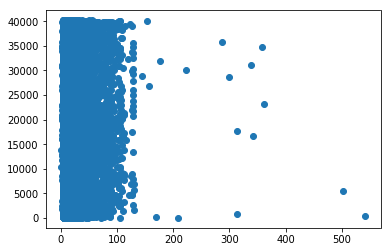

In [71]:
encoded_test_set = t.texts_to_sequences(df_test.cleaned_hm2)
lengths = []
for doc in encoded_test_set:
    lengths.append(len(doc))
    
plt.scatter(lengths, range(len(lengths)))
plt.show()

In [72]:
df_test['tokens'] = encoded_test_set

In [73]:
df_test.head()

,hmid,reflection_period,cleaned_hm2,tokens
0,88305,3m,i spent the weekend in chicago with my friends .,"[1, 203, 6, 180, 10, 1934, 12, 2, 50]"
1,88306,3m,we moved back into our house after a remodel ....,"[22, 419, 104, 150, 56, 115, 45, 3, 5127, 22, ..."
2,88307,3m,my fiance proposed to me in front of my family...,"[2, 684, 1764, 4, 9, 10, 567, 11, 2, 51, 10, 6..."
3,88308,3m,i ate lobster at a fancy restaurant with some ...,"[1, 166, 4649, 20, 3, 1519, 245, 12, 46, 50]"
4,88309,3m,i went out to a nice restaurant on a date with...,"[1, 23, 29, 4, 3, 85, 245, 16, 3, 321, 12, 2, ..."


In [74]:
df_test.drop(['cleaned_hm2'], axis=1, inplace=True)
df_test.head()

,hmid,reflection_period,tokens
0,88305,3m,"[1, 203, 6, 180, 10, 1934, 12, 2, 50]"
1,88306,3m,"[22, 419, 104, 150, 56, 115, 45, 3, 5127, 22, ..."
2,88307,3m,"[2, 684, 1764, 4, 9, 10, 567, 11, 2, 51, 10, 6..."
3,88308,3m,"[1, 166, 4649, 20, 3, 1519, 245, 12, 46, 50]"
4,88309,3m,"[1, 23, 29, 4, 3, 85, 245, 16, 3, 321, 12, 2, ..."


In [75]:
np.mean(lengths)

17.13082833909432

In [77]:
padded_test_set = pad_sequences(encoded_test_set, maxlen=SEQ_LEN, padding='post')
paddocs_test = []
for doc in padded_test_set:
    paddocs_test.append(list(doc))
    
df_test['tokens2'] = paddocs_test
lengths = []
for doc in paddocs_test:
    lengths.append(len(doc))
np.mean(lengths)

120.0

In [78]:
df_test.drop(['tokens'], axis=1, inplace=True)
df_test['tokens'] = df_test.tokens2
df_test.drop(['tokens2'], axis=1, inplace=True)
df_test.head()

,hmid,reflection_period,tokens
0,88305,3m,"[1, 203, 6, 180, 10, 1934, 12, 2, 50, 0, 0, 0,..."
1,88306,3m,"[22, 419, 104, 150, 56, 115, 45, 3, 5127, 22, ..."
2,88307,3m,"[2, 684, 1764, 4, 9, 10, 567, 11, 2, 51, 10, 6..."
3,88308,3m,"[1, 166, 4649, 20, 3, 1519, 245, 12, 46, 50, 0..."
4,88309,3m,"[1, 23, 29, 4, 3, 85, 245, 16, 3, 321, 12, 2, ..."


In [79]:
df_test['24h'] = df_test.reflection_period == '24h'
df_test['3m'] = df_test.reflection_period == '3m'
df_test.drop(['reflection_period'], axis=1, inplace=True)
df_test.head()

,hmid,tokens,24h,3m
0,88305,"[1, 203, 6, 180, 10, 1934, 12, 2, 50, 0, 0, 0,...",False,True
1,88306,"[22, 419, 104, 150, 56, 115, 45, 3, 5127, 22, ...",False,True
2,88307,"[2, 684, 1764, 4, 9, 10, 567, 11, 2, 51, 10, 6...",False,True
3,88308,"[1, 166, 4649, 20, 3, 1519, 245, 12, 46, 50, 0...",False,True
4,88309,"[1, 23, 29, 4, 3, 85, 245, 16, 3, 321, 12, 2, ...",False,True


In [80]:
df_test.shape

(40213, 4)

In [81]:
x_test = df_test.tokens
x_test_reshape = x_test.copy()
x_test_reshape.shape
x_test_new = []
for element in x_test_reshape:
    x_test_new.append(np.array(element))

In [82]:
x_test_new = np.array(x_test_new)
x_test_new.shape

(40213, 120)

In [83]:
np.save('D:/Datasets/hackerearth/test_40213_120.npy', arr=x_test_new)

In [84]:
preds = model.predict(x_test_new, batch_size=256)

In [85]:
preds[0]

array([2.6115769e-08, 5.9129420e-06, 2.1525817e-07, 1.8184678e-09,
       7.0859034e-09, 9.9998975e-01, 4.0017248e-06], dtype=float32)

In [86]:
preds.shape

(40213, 7)

In [87]:
categories = []
for pred in preds:
    dummy = np.zeros((7,))
    dummy[np.argmax(pred)] = 1
    categories.append(cats_to_labels[tuple(dummy)])
categories[:5]

['bonding', 'achievement', 'affection', 'bonding', 'affection']

In [88]:
len(categories)

40213

In [122]:
score = model.evaluate(x_val_new, y_val, batch_size=128, verbose=2)

In [123]:
score

[0.7632580749730673, 0.8769167011968831, 0.8775681899881344]

In [124]:
input_tensor = Input(shape=(SEQ_LEN,), dtype='int32')
e = Embedding(VOCAB_SIZE, 300, weights=[embedding_matrix], input_length=SEQ_LEN, trainable=False)(input_tensor)
x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(e)
x = Bidirectional(CuDNNLSTM(64, return_sequences=False))(x)
x = Dense(64, activation='relu')(x)
x = Dense(7, activation='softmax')(x)
model2 = Model(input_tensor, x)

In [125]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 120)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 120, 300)          6249600   
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 120, 256)          440320    
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 128)               164864    
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_10 (Dense)             (None, 7)                 455       
Total params: 6,863,495
Trainable params: 613,895
Non-trainable params: 6,249,600
____________________________________________________________

In [127]:
model2.compile(optimizer=Adam(lr=1e-4, decay=1e-7), loss='categorical_crossentropy', metrics=['accuracy', f1])

In [128]:
model2.fit(x_train_new, y_train, epochs=EPOCHS, verbose=2)

Epoch 1/20
 - 45s - loss: 0.7920 - acc: 0.7363 - f1: 0.6995
Epoch 2/20
 - 44s - loss: 0.4937 - acc: 0.8318 - f1: 0.8290
Epoch 3/20
 - 46s - loss: 0.4368 - acc: 0.8473 - f1: 0.8460
Epoch 4/20
 - 44s - loss: 0.3948 - acc: 0.8595 - f1: 0.8584
Epoch 5/20
 - 53s - loss: 0.3666 - acc: 0.8673 - f1: 0.8670
Epoch 6/20
 - 44s - loss: 0.3477 - acc: 0.8716 - f1: 0.8718
Epoch 7/20
 - 43s - loss: 0.3341 - acc: 0.8777 - f1: 0.8772
Epoch 8/20
 - 49s - loss: 0.3199 - acc: 0.8829 - f1: 0.8822
Epoch 9/20
 - 47s - loss: 0.3088 - acc: 0.8855 - f1: 0.8855
Epoch 10/20
 - 46s - loss: 0.2974 - acc: 0.8897 - f1: 0.8897
Epoch 11/20
 - 51s - loss: 0.2854 - acc: 0.8933 - f1: 0.8937
Epoch 12/20
 - 44s - loss: 0.2770 - acc: 0.8965 - f1: 0.8968
Epoch 13/20
 - 42s - loss: 0.2653 - acc: 0.9009 - f1: 0.9007
Epoch 14/20
 - 42s - loss: 0.2563 - acc: 0.9042 - f1: 0.9045
Epoch 15/20
 - 41s - loss: 0.2465 - acc: 0.9080 - f1: 0.9079
Epoch 16/20
 - 40s - loss: 0.2367 - acc: 0.9113 - f1: 0.9107
Epoch 17/20
 - 40s - loss: 0.2267

In [129]:
model2.save('D:/Datasets/hackerearth/models/word2vec-blstm128-bltsm64-d64-e20.h5')

In [130]:
score = model2.evaluate(x_val_new, y_val, batch_size=256, verbose=2)

In [131]:
score

[0.37643351573643724, 0.8704517199249125, 0.8702053254143707]

In [132]:
input_tensor = Input(shape=(SEQ_LEN,), dtype='int32')
e = Embedding(VOCAB_SIZE, 300, weights=[embedding_matrix], input_length=SEQ_LEN, trainable=False)(input_tensor)
x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(e)
x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(7, activation='softmax')(x)
model3 = Model(input_tensor, x)

In [133]:
model3.compile(optimizer=Adam(lr=1e-4, decay=1e-7), loss='categorical_crossentropy', metrics=['accuracy', f1])

In [135]:
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 120)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 120, 300)          6249600   
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 120, 256)          440320    
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 120, 128)          164864    
_________________________________________________________________
flatten_2 (Flatten)          (None, 15360)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               1966208   
_________________________________________________________________
dense_12 (Dense)             (None, 7)                 903       
Total para

In [140]:
model3.fit(x_train_new, y_train, epochs=10, verbose=2)

Epoch 1/10
 - 52s - loss: 0.2198 - acc: 0.9164 - f1: 0.9164
Epoch 2/10
 - 48s - loss: 0.2057 - acc: 0.9216 - f1: 0.9220
Epoch 3/10
 - 53s - loss: 0.1924 - acc: 0.9265 - f1: 0.9267
Epoch 4/10
 - 48s - loss: 0.1810 - acc: 0.9311 - f1: 0.9309
Epoch 5/10
 - 46s - loss: 0.1669 - acc: 0.9364 - f1: 0.9363
Epoch 6/10
 - 48s - loss: 0.1549 - acc: 0.9412 - f1: 0.9411
Epoch 7/10
 - 46s - loss: 0.1442 - acc: 0.9455 - f1: 0.9454
Epoch 8/10
 - 52s - loss: 0.1337 - acc: 0.9496 - f1: 0.9496
Epoch 9/10
 - 50s - loss: 0.1214 - acc: 0.9541 - f1: 0.9540
Epoch 10/10
 - 47s - loss: 0.1124 - acc: 0.9584 - f1: 0.9584


In [141]:
model3.save('D:/Datasets/hackerearth/models/word2vec-blstm128-bltsm64-f-d128-e20.h5')

In [142]:
score = model3.evaluate(x_val_new, y_val, batch_size=256, verbose=2)

In [143]:
score

[0.4261749853916895, 0.87915457935685, 0.8802816655692153]